# Setup

A quick note: this tutorial is meant to be a continuation of the Perceptron tutorial, also on my website and github. For information on using the MNIST data, check the previous tutorial.

In [1]:
from collections import OrderedDict
import itertools
from matplotlib import pyplot as plt
from mnist import MNIST
import numpy as np
import sys
import time
import torch
import torch.optim as optim

mndata = MNIST('//Users/jeremiahsafe/Documents/Data/MNIST Handwritten')
tX, tY = mndata.load_training()
trainX, trainY = tX[10000:], tY[10000:]
devX, devY = tX[:10000], tY[:10000]
testX, testY = mndata.load_testing()

input_dim = len(trainX[0])

# Data

We're working with the same MNIST data as before. This time, however, we'll load it into PyTorch tensors.

In [2]:
trainX, trainY = torch.FloatTensor(trainX), torch.FloatTensor(trainY)
devX, devY = torch.FloatTensor(devX), torch.FloatTensor(devY)
testX, testY = torch.FloatTensor(testX), torch.FloatTensor(testY)

This is important so that we can have all the dimensions work out nicely.

# Model: Multiclass Perceptron

Before we go any further building an artificial neural network, lets review a bit of pytorch to build a multiclass perceptron like we did in the previous tutorial.

In [3]:
class MulticlassPerceptron(torch.nn.Module):
    def __init__(self, in_dim, class_count):
        super(MulticlassPerceptron, self).__init__()
        self.fc1 = torch.nn.Linear(in_dim, class_count)
        
    def forward(self, x):
        x = self.fc1(x)
        return x
    
    def eval(self, xs, ys):
        with torch.no_grad():
            correct = 0
            for i in range(len(xs)):
                x = xs[i]
                y = ys[i]
                _, pred = torch.max(self.forward(x), 0)
                if pred == y:
                    correct += 1
            return correct / len(xs)

mcp_model = MulticlassPerceptron(784, 10)

Now let's use pytorch to train this model.

In [4]:
loss_fn = torch.nn.MultiMarginLoss()
optimizer = torch.optim.SGD(mcp_model.parameters(), lr = .001)

print("Dev: {}".format(mcp_model.eval(devX, devY)))

for n in range(5):
    running_loss = 0.0
    for i, x in enumerate(trainX):
        x = x.reshape(-1, 784)
        y = trainY[i].reshape(-1).long()

        optimizer.zero_grad()
        out = mcp_model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10000 == 9999:
            print("[{}, {}] loss = {}".format(n+1, i+1, running_loss / 10000))
            running_loss = 0.0
    
    print("Dev: {}".format(mcp_model.eval(devX, devY)))
    n += 1

Dev: 0.0634
[1, 10000] loss = 24.97927545364946
[1, 20000] loss = 20.127756471133978
[1, 30000] loss = 20.72747439276278
[1, 40000] loss = 20.537979802033306
[1, 50000] loss = 16.86799437030554
Dev: 0.8607
[2, 10000] loss = 17.305116300489008
[2, 20000] loss = 17.870431234744004
[2, 30000] loss = 17.596233497576417
[2, 40000] loss = 18.301473898595944
[2, 50000] loss = 14.694299897130392
Dev: 0.8675
[3, 10000] loss = 16.369076794952527
[3, 20000] loss = 16.4697826064907
[3, 30000] loss = 16.441681869981437
[3, 40000] loss = 17.09276946356818
[3, 50000] loss = 13.60292130741626
Dev: 0.8691
[4, 10000] loss = 15.701486001452803
[4, 20000] loss = 15.80444002498649
[4, 30000] loss = 16.2676709642943
[4, 40000] loss = 16.24744465517476
[4, 50000] loss = 13.542230412778538
Dev: 0.8734
[5, 10000] loss = 15.102588326592556
[5, 20000] loss = 15.225714447802027
[5, 30000] loss = 15.874950566102378
[5, 40000] loss = 16.082070874414594
[5, 50000] loss = 13.203678386262805
Dev: 0.8765


In [5]:
print("Test: {}".format(mcp_model.eval(testX, testY)))

Test: 0.8757


We can see that the model achieves decent accuracy on the task quite quickly.

Because each of the neurons in the output corresponds to one of the digits, and that neurons weights correspond to the weight it gives each pixel in the source image, we can use a simple technique to visualize what each neuron "sees":

In [6]:
def plot_weight_grid(weights):
    weights = weights.reshape(28,28)
    plt.matshow(weights)
    plt.show()

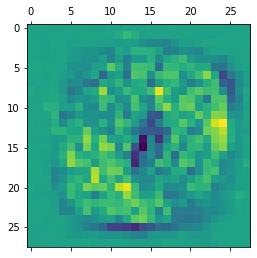

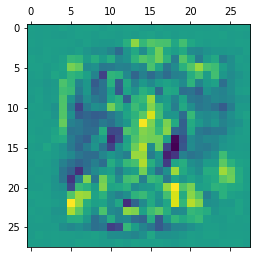

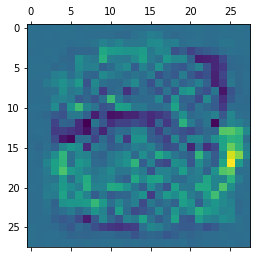

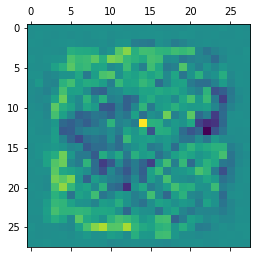

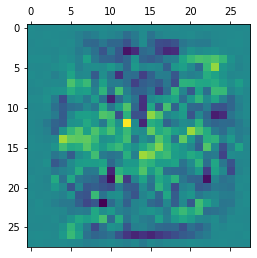

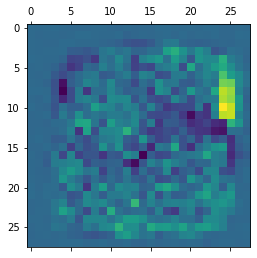

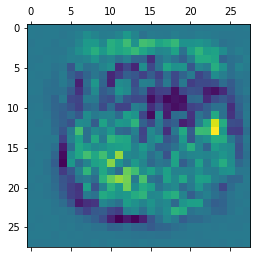

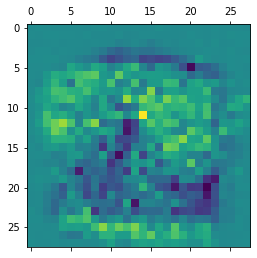

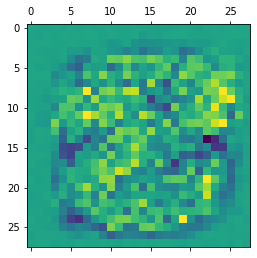

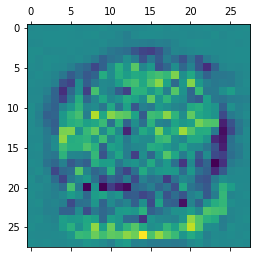

In [7]:
for i in range(10):
    weights = mcp_model.state_dict()['fc1.weight'][i]
    plot_weight_grid(weights)

Pretty cool! You can see how each neuron learns which pixels have a high correlation, or a negative correlation, with the corersponding digit.

# Model: Artificial Neural Network

In order to improve the model, we can introduce more layers. This allows the model to discover intermediate features, not just the ones that directly correspond to each final class. For some tasks, this exploration of feature space is really important. It's as useful for the simple digit classification problem as it is for general-purpose object recognition, unfortunately.

We also introduce nonlinearities to the network. Without a nonlinearity, all a neural network is doing is learning a very complicated linear classifier. This fact was an important factor in the AI Winter, when people became very disillusioned with the potential of machine learning.

In [9]:
class SimpleANN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, class_count):
        super(SimpleANN, self).__init__()
        self.fc1 = torch.nn.Linear(in_dim, hidden_dim)
        self.tanh = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(hidden_dim, class_count)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x
    
    def eval(self, xs, ys):
        with torch.no_grad():
            correct = 0
            for i in range(len(xs)):
                x = xs[i]
                y = ys[i]
                _, pred = torch.max(self.forward(x), 0)
                if pred == y:
                    correct += 1
            return correct / len(xs)

ann_model = SimpleANN(784, 32, 10)

Now we can use pytorch to train the artificial neural network.

In [10]:
loss_fn = torch.nn.MultiMarginLoss()
optimizer = torch.optim.SGD(ann_model.parameters(), lr = .001, momentum = 0.9)

checkpoint = 0
history = {}
history[0] = {}
history[0]['dev'] = ann_model.eval(devX, devY)
history[0]['train'] = ann_model.eval(trainX, trainY)
history[0]['test'] = ann_model.eval(testX, testY)
history[0]['state'] = ann_model.state_dict()
print("Dev: {}".format(history[0]['dev']))

n = 1
max_epochs = 30
min_epochs = 5
running = True
while running:
    running_loss = 0.0
    for i, x in enumerate(trainX):
        x = x.reshape(-1, 784)
        y = trainY[i].reshape(-1).long()

        optimizer.zero_grad()
        out = ann_model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10000 == 9999:
            print("[{}, {}] loss = {}".format(n, i+1, running_loss / 10000))
            running_loss = 0.0
            
    history[n] = {}
    history[n]['dev'] = ann_model.eval(devX, devY)
    history[n]['train'] = ann_model.eval(trainX, trainY)
    history[n]['test'] = ann_model.eval(testX, testY)
    history[n]['state'] = ann_model.state_dict()
    print("Dev: {}".format(history[n]['dev']))
            
    if n >= max_epochs:
        running = False
    
    if history[n]['dev'] < history[n-1]['dev'] and history[n]['test'] > history[n-1]['test'] and n >= min_epochs:
        running = False
        checkpoint = n-1
        
    n += 1

Dev: 0.0684
[1, 10000] loss = 0.9243600019128615
[1, 20000] loss = 0.9347509918753291
[1, 30000] loss = 0.9059391396643827
[1, 40000] loss = 0.9334370576983317
[1, 50000] loss = 0.933384734782431
Dev: 0.1016
[2, 10000] loss = 0.8834764462561813
[2, 20000] loss = 0.8557910890649131
[2, 30000] loss = 0.7030198464870231
[2, 40000] loss = 0.7212217372824369
[2, 50000] loss = 0.7025596584699618
Dev: 0.2137
[3, 10000] loss = 0.695179191291763
[3, 20000] loss = 0.5848234745277551
[3, 30000] loss = 0.591354960996285
[3, 40000] loss = 0.6631470375363624
[3, 50000] loss = 0.599935391501787
Dev: 0.1909
[4, 10000] loss = 0.7655710179522656
[4, 20000] loss = 0.7665427850000931
[4, 30000] loss = 0.7639648682700324
[4, 40000] loss = 0.610854920055985
[4, 50000] loss = 0.5745936573046231
Dev: 0.2228
[5, 10000] loss = 0.5711580398413658
[5, 20000] loss = 0.5679685080280921
[5, 30000] loss = 0.5878422833973371
[5, 40000] loss = 0.5694204779657194
[5, 50000] loss = 0.6883155695266192
Dev: 0.2307
[6, 1000

In [11]:
ann_model.load_state_dict(history[checkpoint]['state'])
print("Test: {}".format(ann_model.eval(testX, testY)))

Test: 0.2959


Although it converges slower than the simple multiclass perceptron, this model is capable of learning finer-grained distinctions than the multiclass perceptron. And, it has hopefully learned some intermediate features in the second layer. In order to understand what this means, let's visualize them -- hopefully this will give us a better sense of how a deep neural network operates!

Each neuron in the 32-unit hidden layer assigns weights to each pixel from the input layer. Over time, each neurons can "learn" a feature from the layer before it.

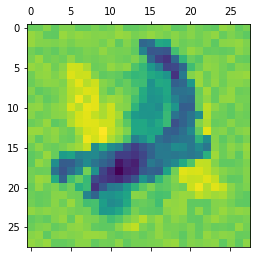

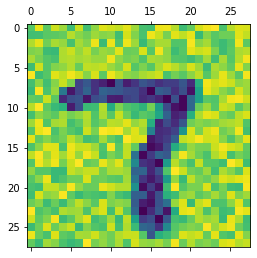

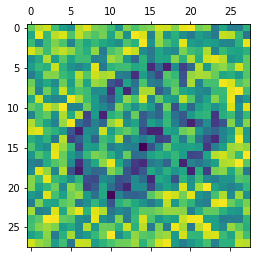

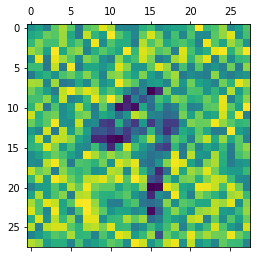

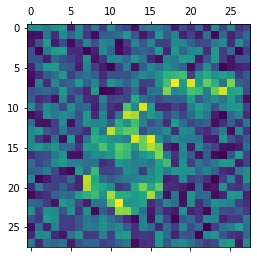

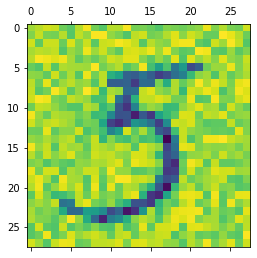

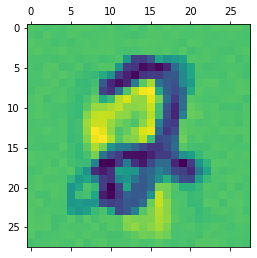

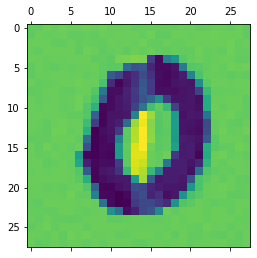

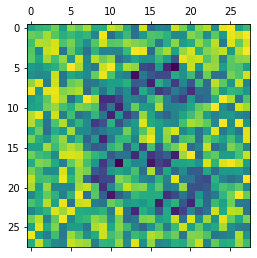

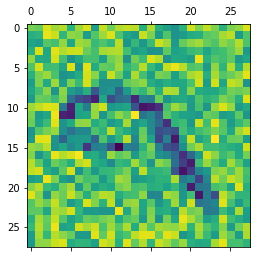

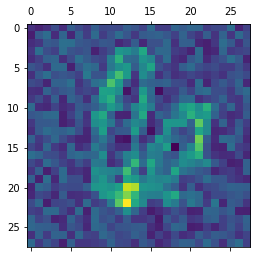

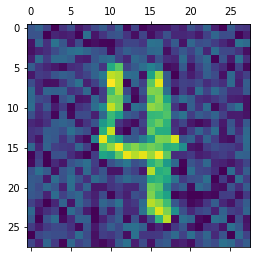

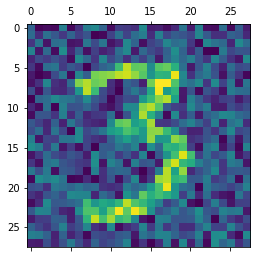

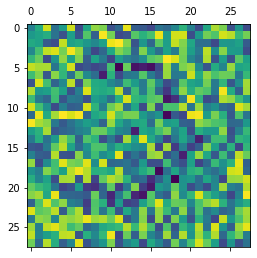

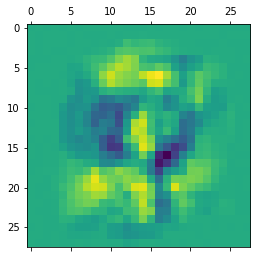

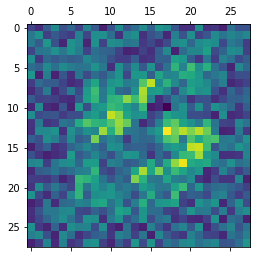

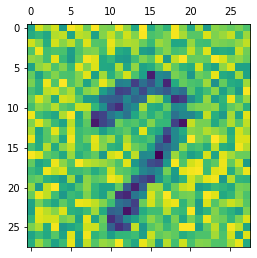

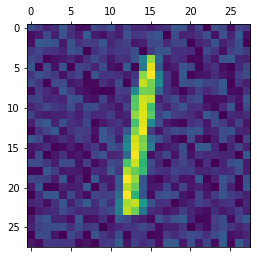

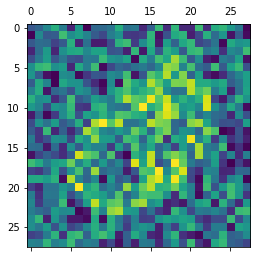

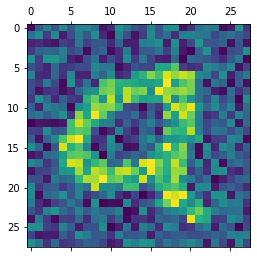

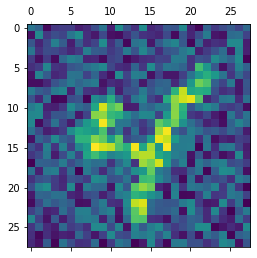

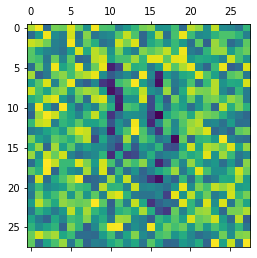

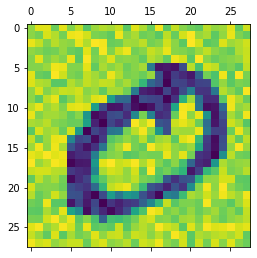

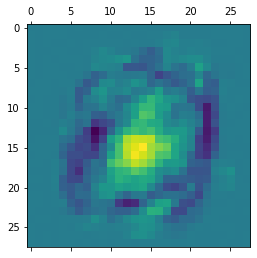

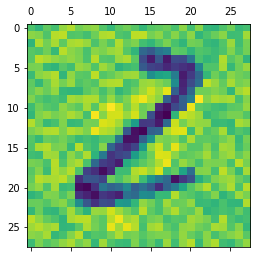

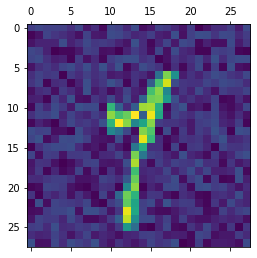

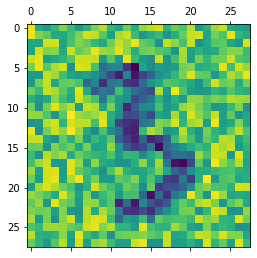

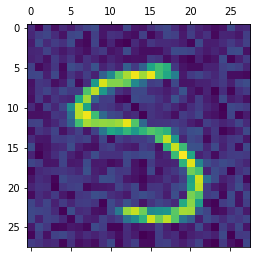

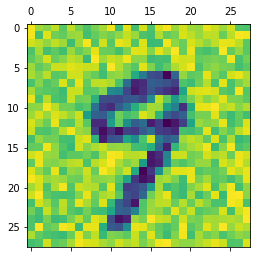

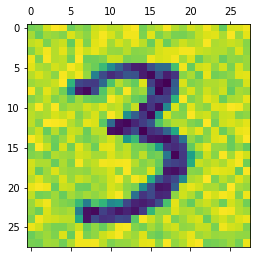

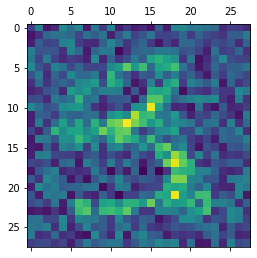

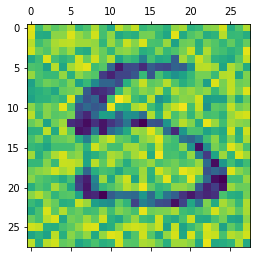

In [12]:
for i in range(32):
    weights = ann_model.state_dict()['fc1.weight'][i]
    plot_weight_grid(weights)

Some of these feature neurons are really noisy, but some of them seem to have discovered features a bit more abstract than in the previous neural network. For example, you might notice some general purpose whorls or lines discovered by these neurons.

It's worth noting that in this example, we have fewer ultimate classes than we do neurons in the hidden layer. In theory, the network *could* converge to something effectively identical to the multiclass perceptron from before -- with 10 of the intermediate layers corresponding to digits, and the final layer of 10 neurons each giving one of those intermediate neurons a weight of 1, and all other intermediate neurons a weight of 0.

However, this type of network is also capable of making more fine-grained distinctions where the simpler network failed. It's more than just a learner for a linear classifier.

# Training Results

Because we kept track of the dev, training, and "secret" test error after each epoch, let's compare how they each change over time.

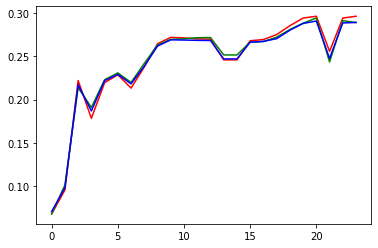

In [13]:
train_accs = [history[i]['train'] for i in range(len(history))]
dev_accs = [history[i]['dev'] for i in range(len(history))]
test_accs = [history[i]['test'] for i in range(len(history))]

plt.plot(test_accs, 'r')
plt.plot(dev_accs, 'g')
plt.plot(train_accs, 'b')

plt.show()

Here we see that I stopped training when dev accuracy went down while test accuracy increased. This "early stopping" technique attempts to avoid the effects of overfitting to the training set.